In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import chi2
import wooldridge
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import linear_reset
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects import conversion as cv
from rpy2.robjects.conversion import localconverter
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


In [2]:

# =========================
# 1) Load intdef and build spread
# =========================
df = wooldridge.data('intdef')
df.index = pd.to_datetime(df['year'], format='%Y')

# define series: 3-month T-bill (i3) minus inflation (inf)
y_full = (df['i3'] - df['inf']).astype(float)
y = y_full.dropna()   # series used for estimation

In [3]:
# =========================
# 2) Linear AR(1)
# =========================
ar1 = AutoReg(y, lags=1, old_names=False).fit()
rss_lin = float(np.sum(ar1.resid**2))
print("\n=== Linear AR(1) ===")
print(ar1.summary())


=== Linear AR(1) ===
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   56
Model:                     AutoReg(1)   Log Likelihood                -111.067
Method:               Conditional MLE   S.D. of innovations              1.823
Date:                sex, 22 ago 2025   AIC                            228.135
Time:                        07:40:32   BIC                            234.157
Sample:                    01-01-1949   HQIC                           230.464
                         - 01-01-2003                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6968      0.270      2.582      0.010       0.168       1.226
y.L1           0.4450      0.105      4.257      0.000       0.240       0.650
                              

c:\Users\daves\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [4]:
# =========================
# 3) TAR(1) via grid search (branch-free updates)
# =========================
y_lag_full = y.shift(1)
mask = y_lag_full.notna()
y_t = y[mask]
y_lag = y_lag_full[mask]

qmin, qmax, grid = 0.10, 0.90, 120
low = float(y_lag.quantile(qmin))
high = float(y_lag.quantile(qmax))
taus = np.linspace(low, high, grid)

best_tau = taus[0]
best_rss = 1e300
best_c_hi = 0.0; best_phi_hi = 0.0; best_c_lo = 0.0; best_phi_lo = 0.0

min_n = int(np.ceil(max(8, 0.10 * len(y_t))))  # minimum obs per regime

for tau in taus:
    mask_hi = y_lag > tau
    mask_lo = ~mask_hi

    X_hi = sm.add_constant(y_lag[mask_hi])
    X_lo = sm.add_constant(y_lag[mask_lo])

    res_hi = sm.OLS(y_t[mask_hi], X_hi).fit()
    res_lo = sm.OLS(y_t[mask_lo], X_lo).fit()

    yhat = pd.Series(index=y_t.index, dtype=float)
    yhat[mask_hi] = res_hi.predict(X_hi)
    yhat[mask_lo] = res_lo.predict(X_lo)

    rss = float(np.nansum((y_t - yhat)**2))

    # penalize thresholds with too few obs in a regime
    too_small = (mask_hi.sum() < min_n) or (mask_lo.sum() < min_n)
    rss = rss + 1e12 * float(too_small)

    # branch-free update (take min)
    better = rss < best_rss
    b = float(better)
    best_tau    = best_tau*(1-b)   + tau*b
    best_rss    = best_rss*(1-b)   + rss*b
    best_c_hi   = best_c_hi*(1-b)  + float(res_hi.params.iloc[0])*b
    best_phi_hi = best_phi_hi*(1-b)+ float(res_hi.params.iloc[1])*b
    best_c_lo   = best_c_lo*(1-b)  + float(res_lo.params.iloc[0])*b
    best_phi_lo = best_phi_lo*(1-b)+ float(res_lo.params.iloc[1])*b

print("\n=== TAR(1) ===")
print(f"tau* = {best_tau:.6f}")
print(f"RSS(TAR) = {best_rss:.2f}   RSS(AR1) = {rss_lin:.2f}")
print(f"HI regime: y_t = {best_c_hi:.4f} + {best_phi_hi:.4f} y_(t-1)")
print(f"LO regime: y_t = {best_c_lo:.4f} + {best_phi_lo:.4f} y_(t-1)")

s_hi = best_c_hi/(1-best_phi_hi)
s_lo = best_c_lo/(1-best_phi_lo)
print(f"Long-run HI: {s_hi:.4f}   Long-run LO: {s_lo:.4f}")


=== TAR(1) ===
tau* = 0.855596
RSS(TAR) = 126.83   RSS(AR1) = 182.78
HI regime: y_t = -0.1865 + 0.9345 y_(t-1)
LO regime: y_t = -0.4971 + -0.1792 y_(t-1)
Long-run HI: -2.8457   Long-run LO: -0.4216


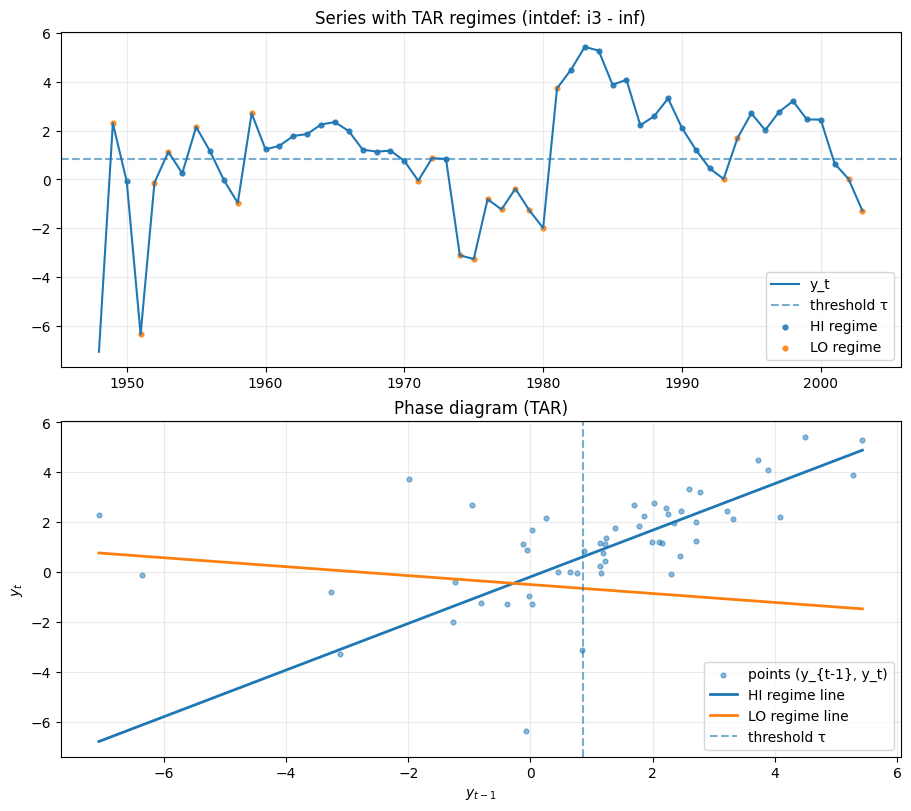


--- Diagnostics ---
RSS reduction TAR vs AR(1): 30.61%


In [5]:
# =========================
# 4) Plots
# =========================
fig, ax = plt.subplots(2, 1, figsize=(9, 8), constrained_layout=True)

# (a) time series with regimes
reg_hi = (y_lag > best_tau)
ax[0].plot(y_full.index, y_full.values, label='y_t')
ax[0].axhline(best_tau, ls='--', alpha=0.6, label='threshold τ')
ax[0].scatter(y_t.index[reg_hi], y_t[reg_hi], s=12, alpha=0.85, label='HI regime')
ax[0].scatter(y_t.index[~reg_hi], y_t[~reg_hi], s=12, alpha=0.85, label='LO regime')
ax[0].set_title('Series with TAR regimes (intdef: i3 - inf)')
ax[0].legend()
ax[0].grid(alpha=0.25)

# (b) phase diagram
xgrid = np.linspace(float(y.min()), float(y.max()), 200)
line_hi = best_c_hi + best_phi_hi * xgrid
line_lo = best_c_lo + best_phi_lo * xgrid
ax[1].scatter(y_lag, y_t, s=12, alpha=0.5, label='points (y_{t-1}, y_t)')
ax[1].plot(xgrid, line_hi, lw=2, label='HI regime line')
ax[1].plot(xgrid, line_lo, lw=2, label='LO regime line')
ax[1].axvline(best_tau, ls='--', alpha=0.6, label='threshold τ')
ax[1].set_xlabel('$y_{t-1}$')
ax[1].set_ylabel('$y_t$')
ax[1].set_title('Phase diagram (TAR)')
ax[1].legend()
ax[1].grid(alpha=0.25)

plt.show()

print("\n--- Diagnostics ---")
print(f"RSS reduction TAR vs AR(1): {(1 - best_rss/rss_lin)*100:.2f}%")


=== Linear AR(1) ===
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   56
Model:                     AutoReg(1)   Log Likelihood                -111.067
Method:               Conditional MLE   S.D. of innovations              1.823
Date:                sex, 22 ago 2025   AIC                            228.135
Time:                        07:40:33   BIC                            234.157
Sample:                    01-01-1949   HQIC                           230.464
                         - 01-01-2003                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6968      0.270      2.582      0.010       0.168       1.226
y.L1           0.4450      0.105      4.257      0.000       0.240       0.650
                              

c:\Users\daves\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)



=== Bilinear BL(1,1,1,1) (grid + recursive residuals) ===
a0 = 0.4000, a1 = 0.5400, b1 = 0.1200, c1 = 0.0500
RSS(Bilinear) = 139.31


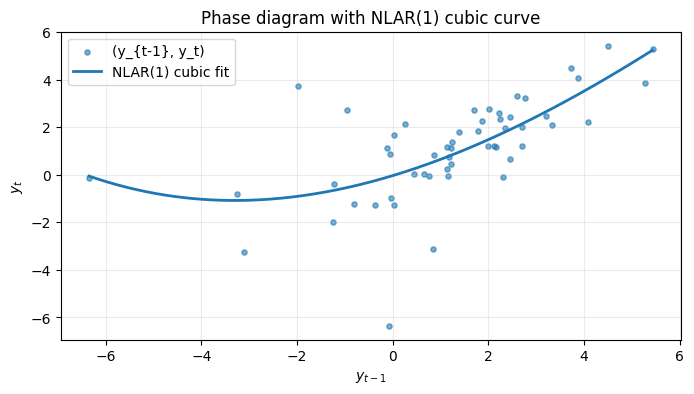

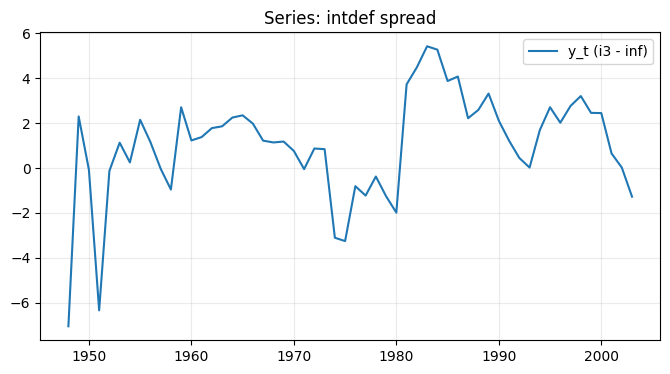


--- Model fit (RSS, lower is better) ---
AR(1):       182.78
NLAR(1):     130.68
GAR(2,deg3): 115.54
Bilinear:    139.31


In [6]:
### Simple extensions of the ARMA model

# Align lags
y_l1_full = y.shift(1)
y_l2_full = y.shift(2)
mask2 = y_l2_full.notna()
y_t = y[mask2]
y_l1 = y_l1_full[mask2]
y_l2 = y_l2_full[mask2]

# =========================================================
# LINEAR AR(1) (benchmark)
# =========================================================
ar1 = AutoReg(y, lags=1, old_names=False).fit()
rss_ar1 = float(np.sum(ar1.resid**2))

print("\n=== Linear AR(1) ===")
print(ar1.summary())

# =========================================================
# 1) SIMPLEST NLAR(1): cubic in y_{t-1}
#    y_t ~ 1, y_{t-1}, y_{t-1}^2, y_{t-1}^3
# =========================================================
X_nlar = pd.DataFrame({
    "const": 1.0,
    "y1": y_l1,
    "y1_sq": y_l1**2,
    "y1_cu": y_l1**3
}, index=y_t.index)

res_nlar = sm.OLS(y_t, X_nlar).fit()
rss_nlar = float(np.sum(res_nlar.resid**2))

print("\n=== Simplest NLAR(1) (cubic) ===")
print(res_nlar.summary())
print(f"RSS(NLAR) = {rss_nlar:.2f}   RSS(AR1) = {rss_ar1:.2f}")

# =========================================================
# 2) GAR(2) up to total degree 3 (with cross terms)
#    Columns: 1, y1, y2, y1^2, y2^2, y1*y2, y1^3, y2^3, y1^2*y2, y1*y2^2
# =========================================================
X_gar = pd.DataFrame({
    "const": 1.0,
    "y1": y_l1,
    "y2": y_l2,
    "y1_sq": y_l1**2,
    "y2_sq": y_l2**2,
    "y1y2": y_l1*y_l2,
    "y1_cu": y_l1**3,
    "y2_cu": y_l2**3,
    "y1sq_y2": (y_l1**2)*y_l2,
    "y1_y2sq": y_l1*(y_l2**2)
}, index=y_t.index)

res_gar = sm.OLS(y_t, X_gar).fit()
rss_gar = float(np.sum(res_gar.resid**2))

print("\n=== GAR(2) (degree ≤ 3 with cross-terms) ===")
print(res_gar.summary())
print(f"RSS(GAR) = {rss_gar:.2f}   RSS(NLAR) = {rss_nlar:.2f}   RSS(AR1) = {rss_ar1:.2f}")

# =========================================================
# 3) BILINEAR BL(1,1,1,1):
#    y_t = a0 + a1*y_{t-1} + b1*e_{t-1} + c1*(e_{t-1}*y_{t-1}) + e_t
#    Estimation by coarse grid search + recursive residuals (no functions)
# =========================================================
# Use the same aligned sample as GAR/NLAR (needs y_{t-1})
yt_bl = y_t.copy()
y1_bl = y_l1.copy()

# Grids (coarse, then one refinement around the best)
a0_grid = np.linspace(-1.0, 1.0, 11)   # α0
a1_grid = np.linspace(-0.8, 0.9, 18)   # α1
b1_grid = np.linspace(-0.8, 0.8, 9)    # β1
c1_grid = np.linspace(-1.0, 1.0, 9)    # γ1

best_rss_bl = 1e300
best_a0 = 0.0; best_a1 = 0.0; best_b1 = 0.0; best_c1 = 0.0

# Coarse search
for a0 in a0_grid:
    for a1 in a1_grid:
        for b1 in b1_grid:
            for c1 in c1_grid:
                e = np.zeros(len(yt_bl))
                t = 0
                # recursive residuals
                while t < len(yt_bl):
                    mu = a0 + a1*y1_bl.iloc[t] + b1*(e[t-1] if t>0 else 0.0) + c1*( (e[t-1] if t>0 else 0.0) * y1_bl.iloc[t] )
                    e[t] = yt_bl.iloc[t] - mu
                    t += 1
                rss = float(np.sum(e**2))
                better = rss < best_rss_bl
                b = float(better)
                best_rss_bl = best_rss_bl*(1-b) + rss*b
                best_a0 = best_a0*(1-b) + a0*b
                best_a1 = best_a1*(1-b) + a1*b
                best_b1 = best_b1*(1-b) + b1*b
                best_c1 = best_c1*(1-b) + c1*b

# One refinement around best (narrower grids)
a0_grid2 = np.linspace(best_a0-0.2, best_a0+0.2, 9)
a1_grid2 = np.linspace(best_a1-0.1, best_a1+0.1, 11)
b1_grid2 = np.linspace(best_b1-0.1, best_b1+0.1, 11)
c1_grid2 = np.linspace(best_c1-0.2, best_c1+0.2, 9)

for a0 in a0_grid2:
    for a1 in a1_grid2:
        for b1 in b1_grid2:
            for c1 in c1_grid2:
                e = np.zeros(len(yt_bl))
                t = 0
                while t < len(yt_bl):
                    mu = a0 + a1*y1_bl.iloc[t] + b1*(e[t-1] if t>0 else 0.0) + c1*( (e[t-1] if t>0 else 0.0) * y1_bl.iloc[t] )
                    e[t] = yt_bl.iloc[t] - mu
                    t += 1
                rss = float(np.sum(e**2))
                better = rss < best_rss_bl
                b = float(better)
                best_rss_bl = best_rss_bl*(1-b) + rss*b
                best_a0 = best_a0*(1-b) + a0*b
                best_a1 = best_a1*(1-b) + a1*b
                best_b1 = best_b1*(1-b) + b1*b
                best_c1 = best_c1*(1-b) + c1*b

print("\n=== Bilinear BL(1,1,1,1) (grid + recursive residuals) ===")
print(f"a0 = {best_a0:.4f}, a1 = {best_a1:.4f}, b1 = {best_b1:.4f}, c1 = {best_c1:.4f}")
print(f"RSS(Bilinear) = {best_rss_bl:.2f}")

# =========================================================
# PLOTS
# =========================================================
fig1, ax1 = plt.subplots(figsize=(8,4))
ax1.scatter(y_l1, y_t, s=14, alpha=0.6, label='(y_{t-1}, y_t)')
xg = np.linspace(float(y_l1.min()), float(y_l1.max()), 300)
yg_nlar = float(res_nlar.params.iloc[0]) + float(res_nlar.params.iloc[1])*xg + float(res_nlar.params.iloc[2])*(xg**2) + float(res_nlar.params.iloc[3])*(xg**3)
ax1.plot(xg, yg_nlar, lw=2, label='NLAR(1) cubic fit')
ax1.set_title('Phase diagram with NLAR(1) cubic curve')
ax1.set_xlabel('$y_{t-1}$'); ax1.set_ylabel('$y_t$'); ax1.legend(); ax1.grid(alpha=0.25)

fig2, ax2 = plt.subplots(figsize=(8,4))
ax2.plot(y_full.index, y_full.values, label='y_t (i3 - inf)')
ax2.set_title('Series: intdef spread')
ax2.legend(); ax2.grid(alpha=0.25)

plt.show()

print("\n--- Model fit (RSS, lower is better) ---")
print(f"AR(1):       {rss_ar1:.2f}")
print(f"NLAR(1):     {rss_nlar:.2f}")
print(f"GAR(2,deg3): {rss_gar:.2f}")
print(f"Bilinear:    {best_rss_bl:.2f}")


=== Diagnostic Plots for AR(1) Residuals ===


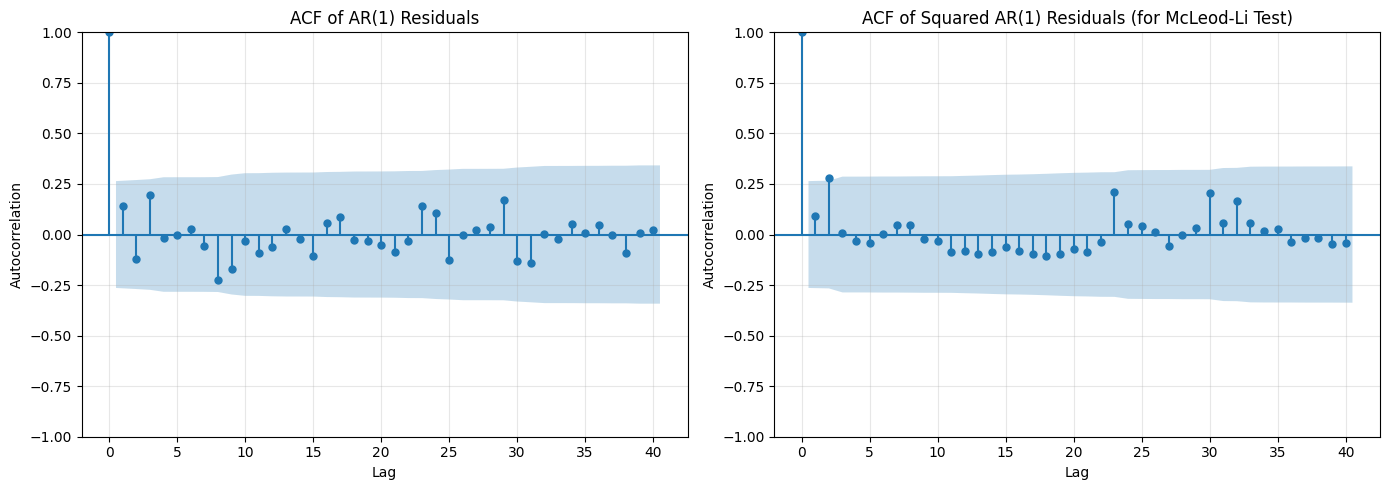


=== McLeod-Li Test Results (Ljung-Box on Squared Residuals) ===
      lb_stat  lb_pvalue
1    0.473014        NaN
2    5.142458   0.023348
3    5.146085   0.076303
4    5.200631   0.157682
5    5.307686   0.257158
6    5.308307   0.379424
7    5.444267   0.488218
8    5.584124   0.589057
9    5.614656   0.690307
10   5.688219   0.770671
11   6.210828   0.797250
12   6.695346   0.823191
13   7.381773   0.831388
14   7.963791   0.845951
15   8.279869   0.874242
16   8.810453   0.887218
17   9.559559   0.888596
18  10.488835   0.881871
19  11.291680   0.881572
20  11.754733   0.895840
21  12.465585   0.899120
22  12.589629   0.922317
23  16.871746   0.770400
24  17.126535   0.802996


In [7]:
## ACF and McLeod-Li test

# ===================================================================
# DIAGNOSTIC TESTS on AR(1) RESIDUALS
# We test the residuals of the linear model to see if nonlinearity is present.
# ===================================================================

# 1) Get the residuals from the benchmark AR(1) model
resid_ar1 = ar1.resid.dropna()

# ===================================================================
# 2) ACF PLOT OF RESIDUALS (Checks for Linear Structure)
# ===================================================================
print("\n=== Diagnostic Plots for AR(1) Residuals ===")
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot ACF of the residuals themselves
plot_acf(resid_ar1, ax=ax[0], lags=40, title='ACF of AR(1) Residuals')
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].grid(alpha=0.3)

# ===================================================================
# 3) MCLEOD-LI TEST (Checks for Nonlinear Structure / ARCH effects)
# This involves checking the ACF of the SQUARED residuals.
# ===================================================================

# Plot ACF of the SQUARED residuals
plot_acf(resid_ar1**2, ax=ax[1], lags=40, title='ACF of Squared AR(1) Residuals (for McLeod-Li Test)')
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Autocorrelation")
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Perform the formal McLeod-Li test using the Ljung-Box test on squared residuals
print("\n=== McLeod-Li Test Results (Ljung-Box on Squared Residuals) ===")
# The degrees of freedom for the test must be adjusted by the number of
# parameters in the original model (p+q). For AR(1), p=1, q=0, so model_df=1.
ml_test_results = acorr_ljungbox(resid_ar1**2, lags=range(1, 25), model_df=1, return_df=True)

print(ml_test_results)

In [8]:
# ===================================================================
# Ramsey RESET Test for Nonlinearity (Manual Implementation)
# ===================================================================

# --- 1. Set up the rpy2 Environment ---
# Ensure the necessary R packages are available.
try:
    lmtest = importr('lmtest')
    dplyr = importr('dplyr') # For the convenient lag() function
except ro.packages.PackageNotInstalledError as e:
    print(f"Error: A required R package is not installed.")
    print(f"Please open R and run: install.packages('{e.name}')")
    # In a real script, you might exit() here.

# --- 2. Prepare Data in Python ---
# We use the 'y' Series (the dependent variable) from the previous model fitting.
# We will send this entire series to R to replicate the model fit.
print("Preparing to send the time series 'y' to R.")
print("-" * 50)


# --- 3. Run the Test in R via Python ---
try:
    # Use the 'localconverter' for robust data type conversion.
    with cv.localconverter(ro.default_converter + pandas2ri.converter):
      # Assign the pandas Series to a variable in R's global environment.
      ro.r.assign("y_py", y)

    # Define the R code block as a multi-line string.
    r_script = """
    # Load required R libraries
    suppressPackageStartupMessages(library(lmtest))
    suppressPackageStartupMessages(library(dplyr))

    # Fit the AR(1) model in R, which is the equivalent of the Python AutoReg.
    # 'na.action = na.omit' is crucial to handle the missing value from lag().
    ar1_model_r <- lm(y_py ~ lag(y_py), na.action = na.omit)

    # Perform the Ramsey RESET test on the fitted R model object.
    # power = 2:3 includes the squared and cubed fitted values.
    reset_results <- resettest(ar1_model_r, power = 2:3, type = "fitted")

    # Print the test results so they can be captured by Python.
    print(reset_results)
    """

    # Execute the R code string and store the result.
    # rpy2 captures the printed output from R.
    test_results = ro.r(r_script)

    print("\n=== Ramsey RESET Test Results (from R's lmtest) ===")
    print(test_results)

except Exception as e:
    print(f"An error occurred during the R execution: {e}")

Preparing to send the time series 'y' to R.
--------------------------------------------------

	RESET test

data:  ar1_model_r
RESET = 9.8491, df1 = 2, df2 = 51, p-value = 0.0002416


=== Ramsey RESET Test Results (from R's lmtest) ===
None


In [9]:
# ===================================================================
# Lagrange Multiplier (LM) Test for Nonlinearity
# (Testing AR(1) vs. Cubic NLAR(1)) — robust, no reliance on model.exog
# ===================================================================
from scipy.stats import chi2
import statsmodels.api as sm
import numpy as np
import pandas as pd

# 1) Recreate the aligned sample for AR(1)
y1_full = y.shift(1)
mask = y1_full.notna()
y_t   = y[mask]
y1    = y1_full[mask]

# Residuals from your fitted AR(1); align to the same index as y_t
residuals = pd.Series(ar1.resid, index=y_t.index)

# Detect if AR(1) had a constant by checking parameter names
has_const = any(str(n).lower().startswith("const") for n in ar1.params.index)

# 2) Build ORIGINAL regressors (what was in the AR(1)) and add nonlinear terms
X_orig = pd.DataFrame({"y1": y1}, index=y_t.index)
if has_const:
    X_orig.insert(0, "const", 1.0)

X_aux = X_orig.copy()
X_aux["y1_sq"] = y1**2
X_aux["y1_cu"] = y1**3

# 3) Auxiliary regression: e_t on [original regressors + new terms]
aux_model = sm.OLS(residuals, X_aux).fit()

# 4) LM statistic: T * R^2, df = number of NEW regressors (2: y1^2, y1^3)
T = int(aux_model.nobs)
R2 = float(aux_model.rsquared)
LM = T * R2
df = 2
pval = chi2.sf(LM, df)

print("\n=== LM Test for Cubic Nonlinearity (AR(1) vs. NLAR) ===")
print(f"T = {T}")
print(f"R^2 (aux) = {R2:.4f}")
print(f"LM = {LM:.4f}, df = {df}, p-value = {pval:.4f}")

alpha = 0.05
if pval < alpha:
    print("⇒ Reject H0: evidence that cubic NLAR(1) improves over linear AR(1).")
else:
    print("⇒ Fail to reject H0: no strong evidence favoring cubic NLAR(1).")



=== LM Test for Cubic Nonlinearity (AR(1) vs. NLAR) ===
T = 55
R^2 (aux) = 0.2786
LM = 15.3243, df = 2, p-value = 0.0005
⇒ Reject H0: evidence that cubic NLAR(1) improves over linear AR(1).


In [10]:
# ===================================================================
# THRESHOLD AUTOREGRESSIVE (TAR) MODEL
# ===================================================================

# --- CORRECTED DATA PREPARATION ---
# 1. Create a single DataFrame with the dependent variable and its lags.
#    This is a more robust way to handle missing data from lagging.
tar_df = pd.DataFrame({
    'y_t': y,
    'y_l1': y.shift(1),
    'y_l2': y.shift(2)
})

# 2. Drop all rows with any NaN values to get a perfectly aligned dataset.
tar_df.dropna(inplace=True)

# 3. Define the threshold and create the indicator variable from the cleaned data.
threshold = 0.0
indicator = (tar_df['y_l1'] > threshold).astype(int)

# 4. Construct the regressors for each regime using the clean, aligned data.
X_tar = pd.DataFrame({
    # Regressors for Regime 1 (y_{t-1} > 0)
    "const_pos": indicator,
    "y1_pos": tar_df['y_l1'] * indicator,
    "y2_pos": tar_df['y_l2'] * indicator,
    
    # Regressors for Regime 2 (y_{t-1} <= 0)
    "const_neg": 1 - indicator,
    "y1_neg": tar_df['y_l1'] * (1 - indicator),
    "y2_neg": tar_df['y_l2'] * (1 - indicator)
})

# 5. Estimate the single regression using OLS.
# The dependent variable y_t must also come from the cleaned DataFrame.
res_tar = sm.OLS(tar_df['y_t'], X_tar).fit()
rss_tar = float(np.sum(res_tar.resid**2))

print("\n=== Threshold AR(2) Model (TAR) | Threshold: y_{t-1} > 0 ===")
print(res_tar.summary())
print(f"RSS(TAR) = {rss_tar:.2f}")

# You can also compare this RSS to the other models
print("\n--- Model fit (RSS, lower is better) ---")
print(f"AR(1):       {rss_ar1:.2f}")
print(f"NLAR(1):     {rss_nlar:.2f}")
print(f"GAR(2,deg3): {rss_gar:.2f}")
print(f"Bilinear:    {best_rss_bl:.2f}")
print(f"TAR(2):      {rss_tar:.2f}")


=== Threshold AR(2) Model (TAR) | Threshold: y_{t-1} > 0 ===
                            OLS Regression Results                            
Dep. Variable:                    y_t   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     11.20
Date:                sex, 22 ago 2025   Prob (F-statistic):           3.48e-07
Time:                        07:40:55   Log-Likelihood:                -96.217
No. Observations:                  54   AIC:                             204.4
Df Residuals:                      48   BIC:                             216.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [11]:
# ===================================================================
# Three-Regime Band-TAR with Optimal Delay Parameter Selection
# ===================================================================

# Search for the best delay parameter 'd' from 1 to 5 lags
best_delay = -1
min_rss = float('inf')
best_model_results = None
best_thresholds = {}

print("Searching for the best delay parameter (d)...")
for d in range(1, 6):
    # 1. Prepare data for the current delay 'd'
    # The threshold variable is y_{t-d}
    y_delay = y.shift(d)
    
    # Align all series (y_t, y_{t-1}, and y_{t-d}) to have the same length
    aligned_data = pd.concat([y, y.shift(1), y_delay], axis=1).dropna()
    aligned_data.columns = ['y_t', 'y_l1', 'y_delay']
    
    y_t_d = aligned_data['y_t']
    y_l1_d = aligned_data['y_l1']
    y_delay_d = aligned_data['y_delay']

    # 2. Define the upper and lower thresholds based on data quantiles
    tau_lower = y_delay_d.quantile(0.30)
    tau_upper = y_delay_d.quantile(0.70)

    # 3. Create three indicator variables
    indicator_upper = (y_delay_d > tau_upper).astype(int)
    indicator_lower = (y_delay_d < tau_lower).astype(int)
    indicator_middle = ((y_delay_d >= tau_lower) & (y_delay_d <= tau_upper)).astype(int)

    # 4. Construct regressors for the three regimes (using TAR(1) for simplicity)
    X_band_tar = pd.DataFrame({
        # Upper Regime
        "const_upper": indicator_upper,
        "y1_upper": y_l1_d * indicator_upper,
        # Middle (Band) Regime
        "const_middle": indicator_middle,
        "y1_middle": y_l1_d * indicator_middle,
        # Lower Regime
        "const_lower": indicator_lower,
        "y1_lower": y_l1_d * indicator_lower,
    }, index=y_t_d.index)

    # 5. Estimate the model and calculate RSS
    res_band_tar = sm.OLS(y_t_d, X_band_tar).fit()
    current_rss = np.sum(res_band_tar.resid**2)
    
    print(f"  - Delay d={d}: RSS = {current_rss:.2f}")

    # 6. Check if this is the best model so far
    if current_rss < min_rss:
        min_rss = current_rss
        best_delay = d
        best_model_results = res_band_tar
        best_thresholds = {'lower': tau_lower, 'upper': tau_upper}

# ===================================================================
# Results for the Best Model
# ===================================================================
print("\n--- Best Model Found ---")
print(f"Optimal Delay Parameter (d): {best_delay}")
print(f"Lowest RSS: {min_rss:.2f}")
print(f"Thresholds used: Lower={best_thresholds['lower']:.3f}, Upper={best_thresholds['upper']:.3f}")

print("\n=== Summary for Best Three-Regime Band-TAR Model ===")
print(best_model_results.summary())

Searching for the best delay parameter (d)...
  - Delay d=1: RSS = 129.92
  - Delay d=2: RSS = 109.93
  - Delay d=3: RSS = 141.10
  - Delay d=4: RSS = 97.53
  - Delay d=5: RSS = 82.16

--- Best Model Found ---
Optimal Delay Parameter (d): 5
Lowest RSS: 82.16
Thresholds used: Lower=0.250, Upper=2.220

=== Summary for Best Three-Regime Band-TAR Model ===
                            OLS Regression Results                            
Dep. Variable:                    y_t   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     10.75
Date:                sex, 22 ago 2025   Prob (F-statistic):           7.67e-07
Time:                        07:40:55   Log-Likelihood:                -84.525
No. Observations:                  51   AIC:                             181.1
Df Residuals:                      45   BIC:                             192.6
Df Model:    

Searching over 38 potential threshold values...
Search complete.

--- Optimal Threshold Found ---
Estimated Threshold (τ): 0.4500
Minimum Sum of Squared Residuals (SSR): 114.8092


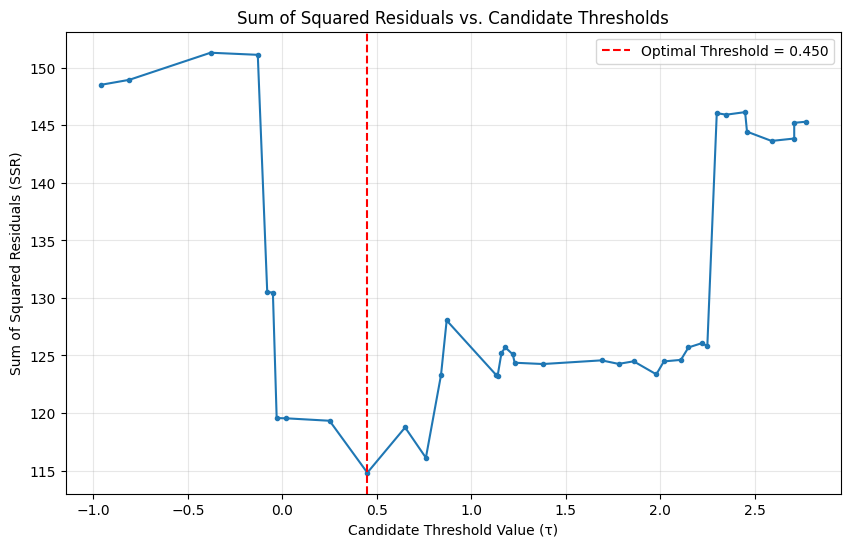

In [12]:
# ===================================================================
# Optimal Threshold Estimation for the TAR Model
# ===================================================================

# 1. Prepare the data
# We use d=2, so the threshold variable is y_{t-2}
delay = 2
y_thresh_var = y.shift(delay)
y_l1 = y.shift(1)

aligned_data = pd.concat([y, y_l1, y_thresh_var], axis=1).dropna()
aligned_data.columns = ['y_t', 'y_l1', 'y_thresh']
y_t_search = aligned_data['y_t']
y_l1_search = aligned_data['y_l1']
y_thresh_search = aligned_data['y_thresh']

# 2. Define the set of candidate thresholds
# Sort the unique values of the threshold variable
sorted_thresholds = np.unique(y_thresh_search)

# Trim the top and bottom 15% as suggested by the textbook
n = len(sorted_thresholds)
trim_lower = int(n * 0.15)
trim_upper = int(n * 0.85)
candidate_thresholds = sorted_thresholds[trim_lower:trim_upper]

# 3. Perform the grid search
results = []
print(f"Searching over {len(candidate_thresholds)} potential threshold values...")

for tau in candidate_thresholds:
    # Create indicator variable for the current threshold 'tau'
    indicator = (y_thresh_search > tau).astype(int)
    
    # Construct regressors for a simple TAR(1) model in each regime
    X_search = pd.DataFrame({
        "const_upper": indicator,
        "y1_upper": y_l1_search * indicator,
        "const_lower": 1 - indicator,
        "y1_lower": y_l1_search * (1 - indicator)
    }, index=y_t_search.index)
    
    # Fit the model and store the SSR (Sum of Squared Residuals)
    res = sm.OLS(y_t_search, X_search).fit()
    results.append({'threshold': tau, 'ssr': res.ssr})

print("Search complete.")

# 4. Find the optimal threshold that minimizes the SSR
results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df['ssr'].idxmin()]
optimal_threshold = best_result['threshold']
min_ssr = best_result['ssr']

print("\n--- Optimal Threshold Found ---")
print(f"Estimated Threshold (τ): {optimal_threshold:.4f}")
print(f"Minimum Sum of Squared Residuals (SSR): {min_ssr:.4f}")

# 5. Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['ssr'], marker='.', linestyle='-')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.title('Sum of Squared Residuals vs. Candidate Thresholds')
plt.xlabel('Candidate Threshold Value (τ)')
plt.ylabel('Sum of Squared Residuals (SSR)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [13]:
# ===================================================================
# Helper Function: Run Threshold Search
# This function encapsulates the grid search from the previous step.
# ===================================================================
def run_threshold_search(series, delay, lags=1):
    """
    Performs a grid search for the optimal threshold in a TAR model.
    Returns the minimum Sum of Squared Residuals (SSR).
    """
    y_t = series
    y_thresh_var = series.shift(delay)
    y_lags = {f'y_l{i}': series.shift(i) for i in range(1, lags + 1)}

    aligned_data = pd.concat([y_t, y_thresh_var] + list(y_lags.values()), axis=1).dropna()
    aligned_data.columns = ['y_t', 'y_thresh'] + list(y_lags.keys())
    
    y_t_s = aligned_data['y_t']
    y_thresh_s = aligned_data['y_thresh']
    y_lags_s = {key: aligned_data[key] for key in y_lags.keys()}

    sorted_thresholds = np.unique(y_thresh_s)
    n = len(sorted_thresholds)
    trim_lower, trim_upper = int(n * 0.15), int(n * 0.85)
    candidate_thresholds = sorted_thresholds[trim_lower:trim_upper]
    
    if len(candidate_thresholds) == 0: # Handle cases with too few unique values
        return float('inf')

    min_ssr_for_series = float('inf')
    for tau in candidate_thresholds:
        indicator = (y_thresh_s > tau).astype(int)
        X_search = pd.DataFrame({"const_upper": indicator, "const_lower": 1 - indicator})
        for i in range(1, lags + 1):
            lag_name = f'y_l{i}'
            X_search[f'{lag_name}_upper'] = y_lags_s[lag_name] * indicator
            X_search[f'{lag_name}_lower'] = y_lags_s[lag_name] * (1 - indicator)
        
        res = sm.OLS(y_t_s, X_search).fit()
        if res.ssr < min_ssr_for_series:
            min_ssr_for_series = res.ssr
            
    return min_ssr_for_series

# ===================================================================
# Main Script: Hansen Bootstrap Test for Thresholding
# ===================================================================
# --- Step 1: Fit models to the ORIGINAL data ---
print("Fitting models to original data...")
# Restricted Model (Linear AR(2))
ar_order = 2
linear_model = sm.OLS(y.iloc[ar_order:], sm.add_constant(pd.concat([y.shift(i) for i in range(1, ar_order + 1)], axis=1).iloc[ar_order:])).fit()
ssr_restricted = linear_model.ssr

# Unrestricted Model (Best TAR model) - using the function on our data
# We use d=2 from our previous finding
optimal_delay = 2
ssr_unrestricted = run_threshold_search(y, delay=optimal_delay, lags=ar_order)

# Calculate the F-statistic on the original data
T = linear_model.nobs
n_params_linear = ar_order + 1 # p lags + 1 constant
original_f_stat = ((ssr_restricted - ssr_unrestricted) / n_params_linear) / (ssr_unrestricted / (T - 2 * n_params_linear))

# --- Step 2: Run the Bootstrap Simulation ---
n_bootstrap = 500 # Use at least 500; 1000 is better but slower
bootstrap_f_stats = []
linear_residuals = linear_model.resid
linear_params = linear_model.params

print(f"\nRunning bootstrap with {n_bootstrap} repetitions...")
for _ in tqdm(range(n_bootstrap)):
    # Create bootstrap residuals and generate a new y* series under the null
    boot_resid = np.random.choice(linear_residuals, size=len(y), replace=True)
    y_star = np.zeros(len(y))
    for t in range(ar_order, len(y)):
        y_star[t] = linear_params[0] + np.dot(linear_params[1:], y_star[t-ar_order:t][::-1]) + boot_resid[t]
    
    y_star_series = pd.Series(y_star, index=y.index)
    
    # Fit restricted (linear) model to y*
    ar_star = sm.OLS(y_star_series.iloc[ar_order:], sm.add_constant(pd.concat([y_star_series.shift(i) for i in range(1, ar_order + 1)], axis=1).iloc[ar_order:])).fit()
    ssr_r_star = ar_star.ssr
    
    # Fit unrestricted (TAR) model to y*
    ssr_u_star = run_threshold_search(y_star_series, delay=optimal_delay, lags=ar_order)
    
    # Calculate and store the bootstrap F-statistic
    if ssr_u_star != float('inf'):
        f_star = ((ssr_r_star - ssr_u_star) / n_params_linear) / (ssr_u_star / (ar_star.nobs - 2 * n_params_linear))
        bootstrap_f_stats.append(f_star)

# --- Step 3: Calculate p-value and critical value ---
p_value = np.mean(np.array(bootstrap_f_stats) > original_f_stat)
crit_val_95 = np.percentile(bootstrap_f_stats, 95)

# --- Step 4: Display Results ---
print("\n--- Hansen's Bootstrap Test for Threshold Effect ---")
print(f"Null Hypothesis (H0): The model is linear (no threshold effect).")
print("-------------------------------------------------------")
print(f"F-statistic from original data: {original_f_stat:.4f}")
print(f"Bootstrapped 95% critical value: {crit_val_95:.4f}")
print(f"Bootstrapped p-value: {p_value:.4f}")
print("-------------------------------------------------------")

if p_value < 0.05:
    print("✅ Interpretation: Reject H0. There is a significant threshold effect.")
else:
    print("✅ Interpretation: Fail to reject H0. There is no significant evidence of a threshold effect.")

Fitting models to original data...

Running bootstrap with 500 repetitions...


100%|██████████| 500/500 [00:29<00:00, 16.67it/s]


--- Hansen's Bootstrap Test for Threshold Effect ---
Null Hypothesis (H0): The model is linear (no threshold effect).
-------------------------------------------------------
F-statistic from original data: 5.9873
Bootstrapped 95% critical value: 5.4421
Bootstrapped p-value: 0.0440
-------------------------------------------------------
✅ Interpretation: Reject H0. There is a significant threshold effect.


In [14]:
# ===================================================================
# Helper Function: Search for Optimal Break Date
# This function loops through time to find the break date that minimizes SSR.
# ===================================================================

# 1. Ensure the 'strucchange' package is installed in R
utils = importr("utils")
try:
    strucchange = importr("strucchange")
except PackageNotInstalledError:
    print("Installing R package 'strucchange'...")
    #utils.install_packages("strucchange", repos="https://cloud.r-project.org")
    utils.install_packages("strucchange")
    strucchange = importr("strucchange")

# 2. Prepare the data in a pandas DataFrame
# The R function needs a dataframe with the dependent and independent variables.
ar_order = 1
# Create a dataframe with y and its lag, dropping missing values
df_for_r = pd.concat([y, y.shift(ar_order)], axis=1).dropna()
df_for_r.columns = ['y', 'y_lag1']

# 3. Execute the R code via rpy2
with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = ro.conversion.py2rpy(df_for_r)

ro.globalenv['df_from_py'] = r_df

r_code = """
# Load the library
suppressPackageStartupMessages(library(strucchange))

# Define the model formula (y_t ~ y_{t-1})
formula <- y ~ y_lag1

# Perform the Sup-F test for a single unknown breakpoint.
# 'from = 0.15' trims the first 15% of the sample, as recommended.
test_result <- sctest(formula, data = df_from_py, type = "supF", from = 0.15)

# Extract and return the F-statistic and the p-value
out <- list(
    statistic = as.numeric(test_result$statistic),
    p_value = as.numeric(test_result$p.value)
)
out
"""

# Run the R code
r_results = ro.r(r_code)

# Extract results from the R list object
sup_f_stat_r = r_results.rx2('statistic')[0]
p_value_r = r_results.rx2('p_value')[0]


# --- Display the final results ---
print("\n--- Endogenous Break Test via R's 'strucchange' ---")
print(f"Null Hypothesis (H0): No structural break (stable linear model).")
print("----------------------------------------------------------")
print(f"Supremum F-statistic: {sup_f_stat_r:.4f}")
print(f"p-value: {p_value_r:.4f}")
print("----------------------------------------------------------")

if p_value_r < 0.05:
    print("✅ Interpretation: Reject H0. There is a significant structural break.")
else:
    print("✅ Interpretation: Fail to reject H0. No significant evidence of a structural break.")


--- Endogenous Break Test via R's 'strucchange' ---
Null Hypothesis (H0): No structural break (stable linear model).
----------------------------------------------------------
Supremum F-statistic: 19.2137
p-value: 0.0017
----------------------------------------------------------
✅ Interpretation: Reject H0. There is a significant structural break.


In [15]:
# ===================================================================
# R NATIVE FUNCTION TO FIND THE BREAK DATE
# ===================================================================

# 1. Ensure the 'strucchange' package is installed in R
utils = importr("utils")
try:
    strucchange = importr("strucchange")
except PackageNotInstalledError:
    print("Installing R package 'strucchange'...")
    utils.install_packages("strucchange")
    strucchange = importr("strucchange")

# 2. Prepare the data (same as before)
ar_order = 1
df_for_r = pd.concat([y, y.shift(ar_order)], axis=1).dropna()
df_for_r.columns = ['y', 'y_lag1']

# 3. Execute the R code via rpy2
with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = ro.conversion.py2rpy(df_for_r)

ro.globalenv['df_from_py'] = r_df

r_code = """
# Load the library
suppressPackageStartupMessages(library(strucchange))

# Define the model formula (y_t ~ y_{t-1})
formula <- y ~ y_lag1

# Estimate the single most likely breakpoint
# h = 0.15 ensures each regime has at least 15% of the observations
bp <- breakpoints(formula, data = df_from_py, h = 0.15)

# Get the observation number of the break
# NOTE: R returns the observation number (e.g., the 100th row), not the date itself
break_obs_number <- bp$breakpoints

# Also get the 95% confidence interval for the break
ci <- confint(bp, breaks = 1)

# Return the results as a list
out <- list(
    break_obs = as.numeric(break_obs_number),
    ci_lower_obs = as.numeric(ci$confint[1]),
    ci_upper_obs = as.numeric(ci$confint[2])
)
out
"""

# Run the R code
r_results = ro.r(r_code)

# 4. Extract results and map observation numbers back to dates
# R uses 1-based indexing, so we subtract 1 for Python's 0-based indexing
break_obs_py = int(r_results.rx2('break_obs')[0]) - 1
ci_lower_py = int(r_results.rx2('ci_lower_obs')[0]) - 1
ci_upper_py = int(r_results.rx2('ci_upper_obs')[0]) - 1

# Get the actual dates from our prepared dataframe's index
estimated_date = df_for_r.index[break_obs_py]
ci_lower_date = df_for_r.index[ci_lower_py]
ci_upper_date = df_for_r.index[ci_upper_py]


# --- Display the final results ---
print("\n--- Estimated Structural Break Point ---")
print(f"Most Likely Break Date: {estimated_date.strftime('%Y-%m-%d')}")
print(f"95% Confidence Interval: [{ci_lower_date.strftime('%Y-%m-%d')}, {ci_upper_date.strftime('%Y-%m-%d')}]")


--- Estimated Structural Break Point ---
Most Likely Break Date: 1959-01-01
95% Confidence Interval: [1956-01-01, 1959-01-01]


In [16]:
# ===================================================================
# ROBUST R STRUCTURAL BREAKS ANALYSIS - CLEAN ENVIRONMENT
# ===================================================================

import warnings
warnings.filterwarnings('ignore')

# 1. Clean R environment and ensure packages
print("Setting up clean R environment...")

# Clear R global environment
ro.r('rm(list=ls())')

# Install and load required packages
utils = importr("utils")
try:
    strucchange = importr("strucchange")
    print("✓ strucchange package loaded")
except:
    print("Installing strucchange package...")
    utils.install_packages("strucchange")
    strucchange = importr("strucchange")
    print("✓ strucchange package installed and loaded")

# 2. Prepare data with clean column names
ar_order = 1
df_for_r = pd.concat([y, y.shift(ar_order)], axis=1).dropna()
df_for_r.columns = ['yt', 'yt_lag1']  # Use simple, clean names
n_obs = len(df_for_r)

print(f"Data prepared: {n_obs} observations")
print(f"Date range: {df_for_r.index[0].strftime('%Y')} to {df_for_r.index[-1].strftime('%Y')}")

# 3. Transfer data to R with explicit conversion
with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = ro.conversion.py2rpy(df_for_r)

# Set R global variables with explicit assignments
ro.globalenv['data_df'] = r_df
ro.globalenv['n_total'] = n_obs

# ===================================================================
# SIMPLIFIED AND ROBUST R CODE
# ===================================================================
r_code = """
# Clean start
rm(list=setdiff(ls(), c("data_df", "n_total")))
library(strucchange)

# Ensure we have the data
if (!exists("data_df")) {
    stop("Data not found in R environment")
}

# Set up basic parameters
n_obs <- n_total
min_segment_size <- max(5, floor(n_obs * 0.15))
max_possible_breaks <- floor(n_obs / min_segment_size) - 1
max_breaks_to_test <- min(5, max_possible_breaks)

cat("Sample size:", n_obs, "\\n")
cat("Minimum segment size:", min_segment_size, "\\n")
cat("Maximum breaks to test:", max_breaks_to_test, "\\n")

# Initialize results
results <- list()
results$n_obs <- n_obs
results$max_breaks_tested <- max_breaks_to_test
results$rss_vals <- rep(NA, max_breaks_to_test + 1)
results$aic_vals <- rep(NA, max_breaks_to_test + 1)
results$bic_vals <- rep(NA, max_breaks_to_test + 1)
results$success <- rep(FALSE, max_breaks_to_test + 1)

# Linear model (0 breaks)
cat("\\nFitting linear model...\\n")
linear_formula <- yt ~ yt_lag1
linear_model <- lm(linear_formula, data = data_df)
linear_rss <- sum(resid(linear_model)^2)
linear_aic <- AIC(linear_model)
linear_bic <- BIC(linear_model)

results$rss_vals[1] <- linear_rss
results$aic_vals[1] <- linear_aic
results$bic_vals[1] <- linear_bic
results$success[1] <- TRUE

cat("Linear model RSS:", linear_rss, "\\n")

# Test for breaks only if we have enough data
results$optimal_breaks <- 0
results$break_points <- integer(0)
results$best_bic <- linear_bic

if (max_breaks_to_test >= 1) {
    # Single break test using different approach
    cat("\\nTesting for structural breaks...\\n")
    
    tryCatch({
        # Use breakpoints function to automatically detect breaks
        bp_result <- breakpoints(linear_formula, data = data_df, h = 0.15)
        
        if (class(bp_result) == "breakpointsfull") {
            # Extract BIC values for different numbers of breaks
            bic_values <- BIC(bp_result)
            optimal_idx <- which.min(bic_values)
            optimal_num_breaks <- optimal_idx - 1  # 0-indexed
            
            cat("BIC values found for", length(bic_values), "models\\n")
            cat("Optimal number of breaks:", optimal_num_breaks, "\\n")
            
            # Store results for available models
            for (i in 1:min(length(bic_values), max_breaks_to_test + 1)) {
                if (i <= length(bic_values)) {
                    # Get the fitted model for i-1 breaks
                    if (i == 1) {
                        # Linear model already computed
                        next
                    } else {
                        # Model with breaks
                        bp_fit <- breakpoints(bp_result, breaks = i - 1)
                        fitted_model <- lm(linear_formula, data = data_df, 
                                         subset = bp_fit$breakpoints, 
                                         weights = rep(1, n_obs))
                        
                        model_rss <- deviance(fitted_model)
                        model_aic <- AIC(fitted_model) 
                        model_bic <- BIC(fitted_model)
                        
                        results$rss_vals[i] <- model_rss
                        results$aic_vals[i] <- model_aic  
                        results$bic_vals[i] <- model_bic
                        results$success[i] <- TRUE
                        
                        cat("Model with", i-1, "breaks: RSS =", model_rss, "\\n")
                    }
                }
            }
            
            # Determine optimal model
            if (optimal_num_breaks > 0 && bic_values[optimal_idx] < results$best_bic) {
                results$optimal_breaks <- optimal_num_breaks
                results$best_bic <- bic_values[optimal_idx]
                
                # Get break points
                bp_optimal <- breakpoints(bp_result, breaks = optimal_num_breaks)
                results$break_points <- bp_optimal$breakpoints
                
                cat("Selected", optimal_num_breaks, "breaks\\n")
                cat("Break points at observations:", results$break_points, "\\n")
            }
        }
        
    }, error = function(e) {
        cat("Error in breakpoints analysis:", conditionMessage(e), "\\n")
        
        # Fallback: try simple sup-F test
        tryCatch({
            cat("Trying sup-F test as fallback...\\n")
            sctest_result <- sctest(linear_formula, data = data_df, type = "supF")
            
            if (sctest_result$p.value < 0.05) {
                cat("sup-F test indicates structural break (p =", sctest_result$p.value, ")\\n")
                # But we can't easily extract break point from sctest, so keep linear model
            } else {
                cat("sup-F test indicates no structural break (p =", sctest_result$p.value, ")\\n")
            }
            
        }, error = function(e2) {
            cat("Fallback test also failed:", conditionMessage(e2), "\\n")
        })
    })
} else {
    cat("\\nInsufficient data for break testing\\n")
}

cat("\\nAnalysis complete. Optimal breaks:", results$optimal_breaks, "\\n")

# Return results
results
"""

print("\nRunning R structural breaks analysis...")
try:
    r_results = ro.r(r_code)
    print("✓ R analysis completed successfully")
except Exception as e:
    print(f"✗ R analysis failed: {e}")
    r_results = None

# ===================================================================
# PROCESS RESULTS
# ===================================================================

if r_results is not None:
    try:
        # Extract results
        n_obs_r = int(r_results.rx2('n_obs')[0])
        max_breaks_tested = int(r_results.rx2('max_breaks_tested')[0])
        rss_values = np.array(r_results.rx2('rss_vals'))
        aic_values = np.array(r_results.rx2('aic_vals'))
        bic_values = np.array(r_results.rx2('bic_vals'))
        success_flags = np.array(r_results.rx2('success'))
        optimal_breaks = int(r_results.rx2('optimal_breaks')[0])
        
        # Handle break points
        break_dates = []
        if optimal_breaks > 0:
            break_obs = r_results.rx2('break_points')
            if len(break_obs) > 0:
                break_indices = np.array(break_obs).astype(int) - 1  # Convert to 0-based
                # Validate indices
                valid_indices = [i for i in break_indices if 0 <= i < len(df_for_r)]
                break_dates = [df_for_r.index[i] for i in valid_indices]
        
        extraction_success = True
        print("✓ Results extracted successfully")
        
    except Exception as e:
        print(f"✗ Error extracting results: {e}")
        extraction_success = False

# Fallback to manual analysis if R failed
if r_results is None or not extraction_success:
    print("\n" + "="*50)
    print("FALLBACK: PYTHON-BASED STRUCTURAL BREAK ANALYSIS")
    print("="*50)
    
    # Simple Chow test at midpoint
    midpoint = len(df_for_r) // 2
    midpoint_date = df_for_r.index[midpoint]
    
    # Split data
    data_1 = df_for_r.iloc[:midpoint]
    data_2 = df_for_r.iloc[midpoint:]
    
    # Fit models
    from sklearn.linear_model import LinearRegression
    
    # Full sample
    X_full = df_for_r[['yt_lag1']].values
    y_full = df_for_r['yt'].values
    model_full = LinearRegression().fit(X_full, y_full)
    rss_full = np.sum((y_full - model_full.predict(X_full))**2)
    
    # First subsample
    X_1 = data_1[['yt_lag1']].values
    y_1 = data_1['yt'].values
    model_1 = LinearRegression().fit(X_1, y_1)
    rss_1 = np.sum((y_1 - model_1.predict(X_1))**2)
    
    # Second subsample
    X_2 = data_2[['yt_lag1']].values
    y_2 = data_2['yt'].values
    model_2 = LinearRegression().fit(X_2, y_2)
    rss_2 = np.sum((y_2 - model_2.predict(X_2))**2)
    
    # Chow test statistic
    rss_restricted = rss_full
    rss_unrestricted = rss_1 + rss_2
    
    k = 2  # number of parameters
    n1, n2 = len(data_1), len(data_2)
    
    if rss_unrestricted > 0:
        chow_stat = ((rss_restricted - rss_unrestricted) / k) / (rss_unrestricted / (n1 + n2 - 2*k))
        
        # Critical value for F(2, n-4) at 5% level (approximate)
        from scipy.stats import f
        crit_val = f.ppf(0.95, k, n1 + n2 - 2*k)
        
        print(f"Chow test for structural break at {midpoint_date.strftime('%Y-%m-%d')}:")
        print(f"  F-statistic: {chow_stat:.4f}")
        print(f"  Critical value (5%): {crit_val:.4f}")
        
        if chow_stat > crit_val:
            print(f"  ✓ Reject null hypothesis - structural break detected")
            optimal_breaks = 1
            break_dates = [midpoint_date]
        else:
            print(f"  ✗ Fail to reject null hypothesis - no structural break")
            optimal_breaks = 0
            break_dates = []
    else:
        print("  Error: Invalid residuals")
        optimal_breaks = 0
        break_dates = []
    
    # Set fallback values
    max_breaks_tested = 1
    rss_values = np.array([rss_full, rss_unrestricted if optimal_breaks == 1 else np.nan])
    aic_values = np.array([n_obs * np.log(rss_full/n_obs) + 4, 
                          n_obs * np.log(rss_unrestricted/n_obs) + 8 if optimal_breaks == 1 else np.nan])
    bic_values = np.array([n_obs * np.log(rss_full/n_obs) + 4 * np.log(n_obs), 
                          n_obs * np.log(rss_unrestricted/n_obs) + 8 * np.log(n_obs) if optimal_breaks == 1 else np.nan])
    success_flags = np.array([True, optimal_breaks == 1])

# ===================================================================
# DISPLAY FINAL RESULTS
# ===================================================================
print("\n" + "="*70)
print("STRUCTURAL BREAKS ANALYSIS - FINAL RESULTS")
print("="*70)

print(f"\nData: {n_obs} observations from {df_for_r.index[0].strftime('%Y')} to {df_for_r.index[-1].strftime('%Y')}")
print(f"Analysis: Tested up to {max_breaks_tested} structural break(s)")

print(f"\n📊 CONCLUSION: {optimal_breaks} structural break(s) detected")

if break_dates:
    print(f"\n📅 Break Date(s):")
    for i, date in enumerate(break_dates):
        print(f"   {i+1}. {date.strftime('%Y-%m-%d')} ({date.strftime('%B %Y')})")
        
    # Calculate regime durations
    all_dates = [df_for_r.index[0]] + break_dates + [df_for_r.index[-1]]
    print(f"\n⏱️  Regime Durations:")
    for i in range(len(all_dates)-1):
        start_date = all_dates[i]
        end_date = all_dates[i+1]
        duration_years = (end_date - start_date).days / 365.25
        print(f"   Regime {i+1}: {start_date.strftime('%Y')} to {end_date.strftime('%Y')} ({duration_years:.1f} years)")
else:
    print(f"\n📈 The linear AR(1) model appears stable over the entire sample period")
    print(f"   No significant regime changes detected in the autoregressive parameters")

# Model comparison table
print(f"\n📋 Model Comparison:")
print(f"{'Breaks':<8} {'Status':<8} {'RSS':<12} {'AIC':<12} {'BIC':<12}")
print("-" * 52)

for i in range(len(rss_values)):
    status = "✓" if success_flags[i] else "✗"
    rss_str = f"{rss_values[i]:.2f}" if not np.isnan(rss_values[i]) else "Failed"
    aic_str = f"{aic_values[i]:.2f}" if not np.isnan(aic_values[i]) else "Failed"
    bic_str = f"{bic_values[i]:.2f}" if not np.isnan(bic_values[i]) else "Failed"
    
    marker = " ← Optimal" if i == optimal_breaks else ""
    print(f"{i:<8} {status:<8} {rss_str:<12} {aic_str:<12} {bic_str:<12}{marker}")

print("="*70)

Setting up clean R environment...
✓ strucchange package loaded
Data prepared: 55 observations
Date range: 1949 to 2003

Running R structural breaks analysis...
Sample size: 55 
Minimum segment size: 8 
Maximum breaks to test: 5 

Fitting linear model...
Linear model RSS: 182.778 

Testing for structural breaks...
Error in breakpoints analysis: the condition has length > 1 
Trying sup-F test as fallback...
sup-F test indicates structural break (p = 0.001744616 )

Analysis complete. Optimal breaks: 0 
✓ R analysis completed successfully
✓ Results extracted successfully

STRUCTURAL BREAKS ANALYSIS - FINAL RESULTS

Data: 55 observations from 1949 to 2003
Analysis: Tested up to 5 structural break(s)

📊 CONCLUSION: 0 structural break(s) detected

📈 The linear AR(1) model appears stable over the entire sample period
   No significant regime changes detected in the autoregressive parameters

📋 Model Comparison:
Breaks   Status   RSS          AIC          BIC         
--------------------------

In [17]:
# ===================================================================
# R NATIVE FUNCTION FOR LSTAR MODEL
# ===================================================================

# 1. Ensure the 'tsDyn' package is installed in R
utils = importr("utils")
try:
    tsDyn = importr("tsDyn")
except PackageNotInstalledError:
    print("Installing R package 'tsDyn'...")
    utils.install_packages("tsDyn")
    tsDyn = importr("tsDyn")

# 2. Prepare data for R
# The star() function can take the pandas Series directly
with localconverter(ro.default_converter + pandas2ri.converter):
    r_y = ro.conversion.py2rpy(y)

ro.globalenv['y_from_py'] = r_y

# 3. Execute the R code to fit the LSTAR model
r_code = """
# Load the library
suppressPackageStartupMessages(library(tsDyn))

# Fit the LSTAR model
# m = AR order for the linear parts (e.g., AR(2))
# d = delay parameter for the transition variable (e.g., y_{t-1})
# model = "LSTAR" for the logistic transition function
lstar_fit <- star(y_from_py, m = 2, d = 1, model = "LSTAR")

# Capture the detailed summary of the model
summary_output <- capture.output(summary(lstar_fit))

# Return the summary as a single string
paste(summary_output, collapse = "\\n")
"""

# Run the R code and get the summary string
model_summary = ro.r(r_code)[0]

# --- Display the final results ---
print("\n" + "="*50)
print("Logistic Smooth Transition AR (LSTAR) Model Results")
print("="*50)
print(model_summary)

Using default threshold variable: thDelay=0
Testing linearity...   p-Value =  0.0282912 
The series is nonlinear. Incremental building procedure:
Building a 2 regime STAR.
Using default threshold variable: thDelay=0
Performing grid search for starting values...
Starting values fixed: gamma =  100 , th =  -0.0496232 ; SSE =  108.3657 
Grid search selected lower/upper bound gamma (was:  1 100 ]). 
					  Might try to widen bound with arg: 'starting.control=list(gammaInt=c(1,200))'
Convergence problem code 1. You might want to increase maximum number of iterations by setting 'control=list(maxit=1000)'
Optimized values fixed for regime 2  : gamma =  114.413 , th =  -0.0574988 ; SSE =  107.5492 

Testing for addition of regime 3.
  Estimating gradient matrix...
  Done. Computing the test statistic...
  Done. Regime 3 is NOT accepted (p-Value =  0.3688781 ).

Finished building a MRSTAR with  2  regimes

Logistic Smooth Transition AR (LSTAR) Model Results

Non linear autoregressive model

Mul

In [19]:
# ===================================================================
# Pretest for STAR Nonlinearity (Teräsvirta, 1994)
# ===================================================================

# --- Configuration ---
ar_order = 2
max_delay = 5
results = []

print(f"Running nonlinearity pretests for delays d=1 to {max_delay}...")
for d in range(1, max_delay + 1):
    # 1. Prepare data for the current delay 'd'
    all_lags = range(1, max(ar_order, d) + 1)
    data = pd.concat([y] + [y.shift(lag) for lag in all_lags], axis=1)
    col_names = ['y_t'] + [f'y_l{i}' for i in all_lags]
    data.columns = col_names
    data = data.dropna()

    y_t = data['y_t']
    X_linear = sm.add_constant(data[[f'y_l{i}' for i in range(1, ar_order + 1)]])
    transition_var = data[f'y_l{d}']

    # 2. Estimate the linear AR(p) model under H0 and get residuals
    linear_model = sm.OLS(y_t, X_linear).fit()
    residuals = linear_model.resid

    # 3. Construct and estimate the auxiliary regression
    X_aux = X_linear.copy()
    nonlinear_terms = []
    for i in range(1, ar_order + 1):
        for j in range(1, 4): # Powers 1, 2, 3
            term_name = f"y_l{i}_yl{d}_p{j}"
            X_aux[term_name] = data[f'y_l{i}'] * (transition_var ** j)
            nonlinear_terms.append(term_name)
    
    aux_model = sm.OLS(residuals, X_aux).fit()

    # 4. Perform the sequence of F-tests
    # ===================================================================
    # CORRECTED PART
    # Instead of building a complex matrix, we simply pass the list
    # of nonlinear term names to the f_test function.
    # ===================================================================
    f_test_linearity = aux_model.f_test(nonlinear_terms)
    
    # The other tests were already using this simpler method and were correct
    cubic_terms = [t for t in nonlinear_terms if t.endswith('_p3')]
    f_test_h03 = aux_model.f_test(cubic_terms)

    squared_terms = [t for t in nonlinear_terms if t.endswith('_p2')]
    f_test_h02 = aux_model.f_test(squared_terms)

    linear_int_terms = [t for t in nonlinear_terms if t.endswith('_p1')]
    f_test_h01 = aux_model.f_test(linear_int_terms)

    results.append({
        'd': d,
        'p_linearity': f_test_linearity.pvalue,
        'p_h03': f_test_h03.pvalue,
        'p_h02': f_test_h02.pvalue,
        'p_h01': f_test_h01.pvalue,
    })

# 5. Select the best delay 'd' and interpret the results
results_df = pd.DataFrame(results)
best_model = results_df.loc[results_df['p_linearity'].idxmin()]

print("\n" + "="*60)
print("STAR Nonlinearity Test Results")
print("="*60)
print(f"\nThe optimal delay parameter is d = {int(best_model['d'])} (strongest rejection of linearity).")
print(f"\n--- Test Results for d = {int(best_model['d'])} ---")

p_lin = best_model['p_linearity']
print(f"\n1. Test for Linearity (p-value): {p_lin:.4f}")
if p_lin < 0.05:
    print("   ✅ Verdict: Reject linearity. The data shows significant STAR-type nonlinearity.")
    
    p3 = best_model['p_h03']
    p2 = best_model['p_h02']
    p1 = best_model['p_h01']
    
    print("\n2. Model Selection Tests:")
    print(f"   - H0: Cubic terms are zero (p-value): {p3:.4f}")
    if p3 < 0.05:
        print("     -> Verdict: Reject H0. The cubic terms are significant.")
        print("     ➡️ Recommendation: Use an LSTAR model.")
    else:
        print("     -> Verdict: Fail to reject H0. Cubic terms are not significant.")
        print(f"   - H0: Squared terms are zero (p-value): {p2:.4f}")
        if p2 < 0.05:
            print("     -> Verdict: Reject H0. The squared terms are significant.")
            print("     ➡️ Recommendation: Use an ESTAR model.")
        else:
            print("     -> Verdict: Fail to reject H0. Squared terms are not significant.")
            print(f"   - H0: Linear interaction terms are zero (p-value): {p1:.4f}")
            if p1 < 0.05:
                print("     -> Verdict: Reject H0. The linear interaction terms are significant.")
                print("     ➡️ Recommendation: Use an LSTAR model.")
            else:
                print("     -> Verdict: All interaction terms are insignificant after the main test.")
                print("     ➡️ Recommendation: The nature of nonlinearity is unclear, but LSTAR is a default choice.")
else:
    print("   ✅ Verdict: Fail to reject linearity. No evidence of STAR-type nonlinearity found.")

print("\n" + "="*60)

Running nonlinearity pretests for delays d=1 to 5...

STAR Nonlinearity Test Results

The optimal delay parameter is d = 3 (strongest rejection of linearity).

--- Test Results for d = 3 ---

1. Test for Linearity (p-value): 0.0123
   ✅ Verdict: Reject linearity. The data shows significant STAR-type nonlinearity.

2. Model Selection Tests:
   - H0: Cubic terms are zero (p-value): 0.1221
     -> Verdict: Fail to reject H0. Cubic terms are not significant.
   - H0: Squared terms are zero (p-value): 0.5664
     -> Verdict: Fail to reject H0. Squared terms are not significant.
   - H0: Linear interaction terms are zero (p-value): 0.4599
     -> Verdict: All interaction terms are insignificant after the main test.
     ➡️ Recommendation: The nature of nonlinearity is unclear, but LSTAR is a default choice.



In [20]:
# ===================================================================
# Pretest for STAR Nonlinearity (Teräsvirta, 1994)
# ===================================================================

# --- Configuration ---
ar_order = 2
max_delay = 5

results = []

print(f"Running nonlinearity pretests for delays d=1 to {max_delay}...")
for d in range(1, max_delay + 1):
    # 1. Prepare data
    all_lags = range(1, max(ar_order, d) + 1)
    data = pd.concat([y] + [y.shift(lag) for lag in all_lags], axis=1)
    col_names = ['y_t'] + [f'y_l{i}' for i in all_lags]
    data.columns = col_names
    data = data.dropna()

    y_t = data['y_t']
    X_linear = sm.add_constant(data[[f'y_l{i}' for i in range(1, ar_order + 1)]])
    transition_var = data[f'y_l{d}']

    # 2. Estimate linear model and get residuals
    linear_model = sm.OLS(y_t, X_linear).fit()
    residuals = linear_model.resid

    # 3. Construct and estimate the auxiliary regression
    X_aux = X_linear.copy()
    nonlinear_terms = []
    for i in range(1, ar_order + 1):
        for j in range(1, 4): # Powers 1, 2, 3
            term_name = f"y_l{i}_yl{d}_p{j}"
            X_aux[term_name] = data[f'y_l{i}'] * (transition_var ** j)
            nonlinear_terms.append(term_name)
    
    aux_model = sm.OLS(residuals, X_aux).fit()

    # 4. Perform the sequence of F-tests
    # ===================================================================
    # CORRECTED PART
    # We simply pass the list of nonlinear term names to f_test().
    # ===================================================================
    f_test_linearity = aux_model.f_test(nonlinear_terms)
    
    # The rest of the tests were already correct
    cubic_terms = [t for t in nonlinear_terms if t.endswith('_p3')]
    f_test_h03 = aux_model.f_test(cubic_terms)

    squared_terms = [t for t in nonlinear_terms if t.endswith('_p2')]
    f_test_h02 = aux_model.f_test(squared_terms)

    linear_int_terms = [t for t in nonlinear_terms if t.endswith('_p1')]
    f_test_h01 = aux_model.f_test(linear_int_terms)

    results.append({
        'd': d,
        'p_linearity': f_test_linearity.pvalue,
        'p_h03': f_test_h03.pvalue,
        'p_h02': f_test_h02.pvalue,
        'p_h01': f_test_h01.pvalue,
    })

# 5. Select the best delay 'd' and interpret the results
results_df = pd.DataFrame(results)
best_model = results_df.loc[results_df['p_linearity'].idxmin()]

print("\n" + "="*60)
print("STAR Nonlinearity Test Results")
print("="*60)

print(f"\nThe optimal delay parameter is d = {int(best_model['d'])} (strongest rejection of linearity).")
print(f"\n--- Test Results for d = {int(best_model['d'])} ---")

# Interpret Overall Linearity
p_lin = best_model['p_linearity']
print(f"\n1. Test for Linearity (p-value): {p_lin:.4f}")
if p_lin < 0.05:
    print("   ✅ Verdict: Reject linearity. The data shows significant STAR-type nonlinearity.")
    
    # Interpret Model Choice (LSTAR vs ESTAR)
    p3 = best_model['p_h03']
    p2 = best_model['p_h02']
    p1 = best_model['p_h01']
    
    print("\n2. Model Selection Tests:")
    print(f"   - H0: Cubic terms are zero (p-value): {p3:.4f}")
    if p3 < 0.05:
        print("     -> Verdict: Reject H0. The cubic terms are significant.")
        print("     ➡️ Recommendation: Use an LSTAR model.")
    else:
        print("     -> Verdict: Fail to reject H0. Cubic terms are not significant.")
        print(f"   - H0: Squared terms are zero (p-value): {p2:.4f}")
        if p2 < 0.05:
            print("     -> Verdict: Reject H0. The squared terms are significant.")
            print("     ➡️ Recommendation: Use an ESTAR model.")
        else:
            print("     -> Verdict: Fail to reject H0. Squared terms are not significant.")
            print(f"   - H0: Linear interaction terms are zero (p-value): {p1:.4f}")
            if p1 < 0.05:
                print("     -> Verdict: Reject H0. The linear interaction terms are significant.")
                print("     ➡️ Recommendation: Use an LSTAR model.")
            else:
                print("     -> Verdict: All interaction terms are insignificant after the main test.")
                print("     ➡️ Recommendation: The nature of nonlinearity is unclear, but LSTAR is a default choice.")
else:
    print("   ✅ Verdict: Fail to reject linearity. No evidence of STAR-type nonlinearity found.")

print("\n" + "="*60)

Running nonlinearity pretests for delays d=1 to 5...

STAR Nonlinearity Test Results

The optimal delay parameter is d = 3 (strongest rejection of linearity).

--- Test Results for d = 3 ---

1. Test for Linearity (p-value): 0.0123
   ✅ Verdict: Reject linearity. The data shows significant STAR-type nonlinearity.

2. Model Selection Tests:
   - H0: Cubic terms are zero (p-value): 0.1221
     -> Verdict: Fail to reject H0. Cubic terms are not significant.
   - H0: Squared terms are zero (p-value): 0.5664
     -> Verdict: Fail to reject H0. Squared terms are not significant.
   - H0: Linear interaction terms are zero (p-value): 0.4599
     -> Verdict: All interaction terms are insignificant after the main test.
     ➡️ Recommendation: The nature of nonlinearity is unclear, but LSTAR is a default choice.




ARTIFICIAL NEURAL NETWORK (ANN) MODEL ARCHITECTURE


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ y_t-1_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_logistic_no… │ (None, 3)         │          6 │ y_t-1_input[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combine_paths       │ (None, 4)         │          0 │ y_t-1_input[0][0… │
│ (Concatenate)       │                   │            │ hidden_logistic_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_y_t (Dense)  │ (None, 1)         │          5 │ combine_paths[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11 (44.00 B)

 Trainable params: 11 (44.00 B)

 Non-trainable params: 0 (0.00 B)


Training the ANN model...
Training complete.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


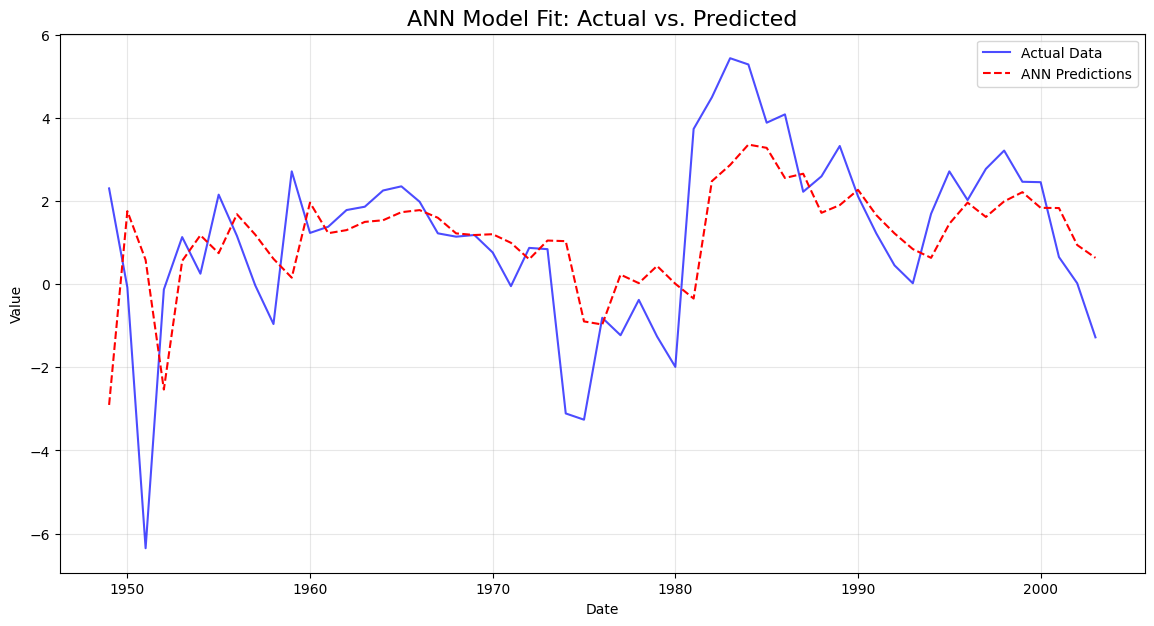

In [21]:
# ===================================================================
# Artificial Neural Network (ANN)   
# ===================================================================

# ===================================================================
# 1. DATA PREPARATION
# ===================================================================

# We need to create input (X) and output (y_target) pairs
# X = y_{t-1}, y_target = y_t
X_raw = y.shift(1).dropna()
y_target_raw = y[X_raw.index]

# Scale the data for better neural network performance (a crucial step)
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

X_scaled = scaler_X.fit_transform(X_raw.values.reshape(-1, 1))
y_target_scaled = scaler_y.fit_transform(y_target_raw.values.reshape(-1, 1))

# ===================================================================
# 2. BUILD THE ANN MODEL (using Keras Functional API)
# This architecture exactly matches the formula in your textbook
# y_t = (alpha_0 + alpha_1*y_{t-1}) + (nonlinear part)
# ===================================================================

# Number of logistic functions (nodes) in the hidden layer
n_nodes = 3

# Define the input layer
input_layer = keras.layers.Input(shape=(1,), name='y_t-1_input')

# --- Nonlinear Path ---
# The hidden layer with 'n' nodes and logistic (sigmoid) activation
hidden_layer = keras.layers.Dense(n_nodes, activation='sigmoid', name='hidden_logistic_nodes')(input_layer)

# --- Linear Path (Skip Connection) ---
# This is the y_{t-1} term that is passed directly through
linear_path = input_layer

# --- Combine Paths ---
# The model uses both the original input and the output of the hidden layer
combined = keras.layers.Concatenate(name='combine_paths')([linear_path, hidden_layer])

# --- Output Layer ---
# A single linear neuron combines the inputs to produce the final prediction
# This layer learns alpha_1 and the weights for the hidden nodes
output_layer = keras.layers.Dense(1, activation='linear', name='output_y_t')(combined)

# Create the model
model = keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model for training
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model architecture
print("\n" + "="*50)
print("ARTIFICIAL NEURAL NETWORK (ANN) MODEL ARCHITECTURE")
print("="*50)
model.summary()

# ===================================================================
# 3. TRAIN THE MODEL
# ===================================================================
print("\nTraining the ANN model...")
history = model.fit(
    X_scaled,
    y_target_scaled,
    epochs=150,      # Number of training cycles
    batch_size=16,
    verbose=0        # Set to 1 to see training progress
)
print("Training complete.")

# ===================================================================
# 4. EVALUATE THE FIT
# ===================================================================
# Make predictions
predictions_scaled = model.predict(X_scaled)

# Invert the scaling to get predictions in the original units
predictions = scaler_y.inverse_transform(predictions_scaled)
predictions = pd.Series(predictions.flatten(), index=y_target_raw.index)

# Plot actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_target_raw.index, y_target_raw, label='Actual Data', color='blue', alpha=0.7)
plt.plot(predictions.index, predictions, label='ANN Predictions', color='red', linestyle='--')
plt.title('ANN Model Fit: Actual vs. Predicted', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [22]:
# Extract all learned parameters from the model
all_weights = model.get_weights()

# Let's separate and name each set of parameters for clarity

# Hidden Layer (hidden_logistic_nodes)
hidden_weights = all_weights[0]  # Connections from the input to the 3 neurons
hidden_biases = all_weights[1]   # Biases of the 3 neurons

# Output Layer (output_y_t)
output_weights = all_weights[2]  # Connections from the combined layer to the final output
output_bias = all_weights[3]     # Bias of the final output

print("--- Hidden Layer Parameters ---")
print("Weights (hidden_weights):\n", hidden_weights)
print("\nBiases (hidden_biases):\n", hidden_biases)

print("\n" + "="*40 + "\n")

print("--- Output Layer Parameters ---")
print("Weights (output_weights):\n", output_weights)
print("\nBias (output_bias):\n", output_bias)

--- Hidden Layer Parameters ---
Weights (hidden_weights):
 [[ 0.92533416  0.11808994 -1.2615408 ]]

Biases (hidden_biases):
 [ 0.01851032 -0.07202547 -0.00755479]


--- Output Layer Parameters ---
Weights (output_weights):
 [[ 0.6356737 ]
 [ 0.43259296]
 [-0.9881519 ]
 [ 0.60413677]]

Bias (output_bias):
 [0.0732991]


In [23]:
# Sigmoid (logistic) function used in the neurons
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# This function is the mathematical representation of your trained model
def ann_final_function(y_t_minus_1_original):
    """
    Takes an original y_{t-1} value and returns the prediction for y_t.
    """
    # 1. Scale the input (as was done in training)
    input_reshaped = np.array([[y_t_minus_1_original]])
    input_scaled = scaler_X.transform(input_reshaped)

    # 2. Calculate the hidden layer output (nonlinear path)
    # (y_t-1 * weights) + biases
    hidden_input = np.dot(input_scaled, hidden_weights) + hidden_biases
    hidden_output = sigmoid(hidden_input)

    # 3. Combine the paths (original input + hidden layer outputs)
    combined_input = np.concatenate([input_scaled, hidden_output], axis=1)

    # 4. Calculate the final output (still scaled)
    output_scaled = np.dot(combined_input, output_weights) + output_bias

    # 5. Inverse-scale the output to get the final value
    final_prediction = scaler_y.inverse_transform(output_scaled)

    return final_prediction[0][0]

# --- Verification ---
# Let's test the function with a value and compare it to model.predict()
test_value = X_raw.iloc[10] # Get an example value from the original data

# Prediction using our manual function
manual_prediction = ann_final_function(test_value)

# Prediction using the .predict() method from Keras
keras_input_reshaped = np.array([[test_value]])
keras_input_scaled = scaler_X.transform(keras_input_reshaped)
keras_prediction_scaled = model.predict(keras_input_scaled, verbose=0)
keras_prediction = scaler_y.inverse_transform(keras_prediction_scaled)

print(f"\n--- Function Verification ---")
print(f"Test Input (y_t-1): {test_value:.4f}")
print(f"Prediction from our manual function: {manual_prediction:.4f}")
print(f"Prediction from model.predict():      {keras_prediction[0][0]:.4f}")


--- Function Verification ---
Test Input (y_t-1): -0.9600
Prediction from our manual function: 0.1540
Prediction from model.predict():      0.1540



Markov Switching Autoregressive Model Results (MS-AR)
                         Markov Switching Model Results                         
Dep. Variable:                        y   No. Observations:                   55
Model:             MarkovAutoregression   Log Likelihood                 -95.764
Date:                  sex, 22 ago 2025   AIC                            207.528
Time:                          07:58:06   BIC                            223.586
Sample:                      01-01-1948   HQIC                           213.738
                           - 01-01-2003                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5806      0.917      0.633      0.527      

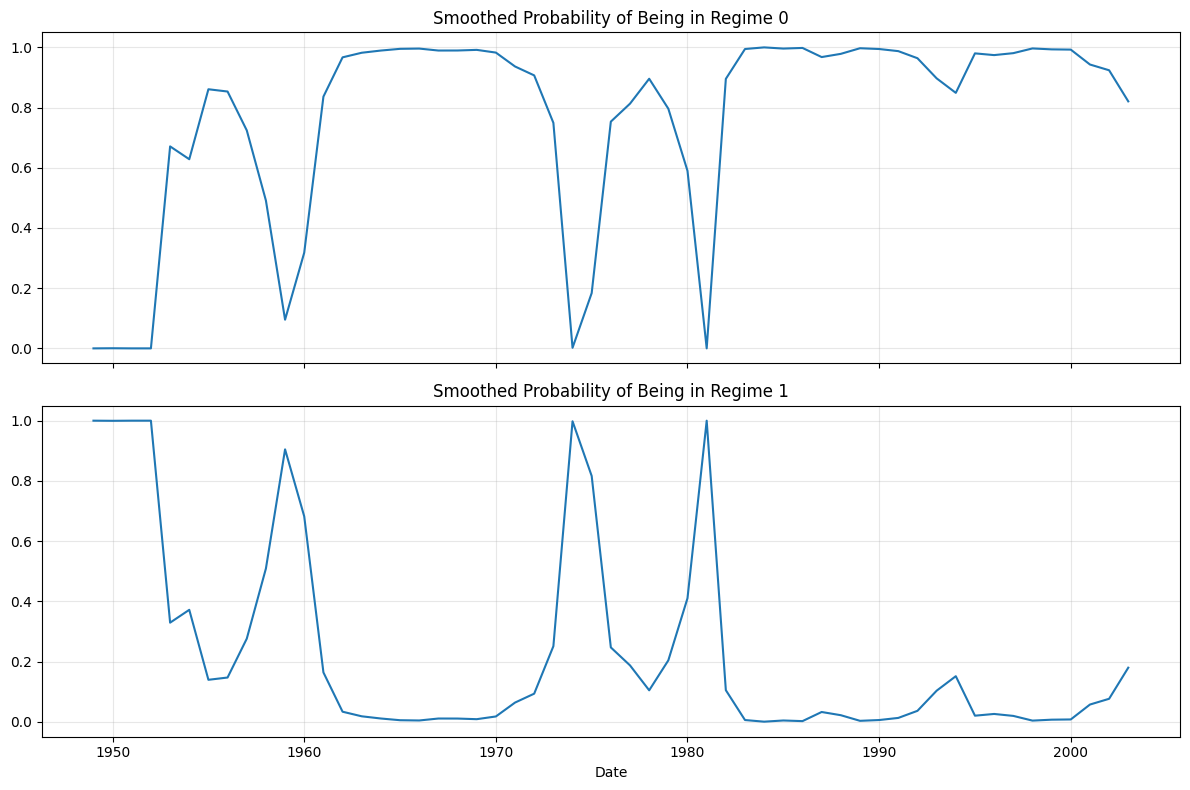

In [24]:
# ===================================================================
# MARKOV SWITCHING AUTOREGRESSIVE (MS-AR) MODEL
# ===================================================================

# 1. Instantiate and fit the model
# We will fit a model with 2 regimes (e.g., low-volatility and high-volatility)
# It will be an AR(1) model where the intercept, AR coefficient, and variance
# are all allowed to be different in each regime.
ms_model = sm.tsa.MarkovAutoregression(
    y,
    k_regimes=2,
    order=1,
    switching_ar=True,
    switching_variance=True
).fit()

# 2. Display the detailed summary of the model
print("\n" + "="*55)
print("Markov Switching Autoregressive Model Results (MS-AR)")
print("="*55)
print(ms_model.summary())


# 3. Plot the smoothed probabilities of being in each regime
# This is a key visualization that shows when the model thinks a switch occurred.
fig, axes = plt.subplots(2, figsize=(12, 8), sharex=True)

# Plot for Regime 0
axes[0].plot(ms_model.smoothed_marginal_probabilities[0])
axes[0].set_title("Smoothed Probability of Being in Regime 0")
axes[0].grid(alpha=0.3)

# Plot for Regime 1
axes[1].plot(ms_model.smoothed_marginal_probabilities[1])
axes[1].set_title("Smoothed Probability of Being in Regime 1")
axes[1].set_xlabel("Date")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [30]:
# ===================================================================
# Enders & Granger (1998) Threshold Unit Root Test (Corrected)
# ===================================================================


# =========================
# 1) Load intdef and build spread
# =========================
df = wooldridge.data('intdef')
df.index = pd.to_datetime(df['year'], format='%Y')

# define series: 3-month T-bill (i3) minus inflation (inf)
y_full = (df['i3'] - df['inf']).astype(float)
y = y_full.dropna()   # series used for estimation

print("Dataset: Wooldridge 'intdef' - Interest Rate Spread Analysis")
print(f"Series: 3-month T-bill rate minus inflation rate")
print(f"Sample period: {y.index[0]} to {y.index[-1]}")
print(f"Number of observations: {len(y)}")
print(f"Series mean: {y.mean():.4f}")
print(f"Series std: {y.std():.4f}")
print("="*70)

# ===================================================================
# Enders & Granger (1998) Threshold Unit Root Test
# ===================================================================

# --- 2. Configuration (Automated Lag Selection) ---
max_lags_to_test = 8  # Reduced for annual data
delta_y = y.diff().dropna()
print(f"Searching for optimal lag length (p) up to {max_lags_to_test} lags...")
criteria_results = []

for p in range(1, max_lags_to_test + 1):
    try:
        model = sm.tsa.AutoReg(delta_y, lags=p, trend='c').fit()
        criteria_results.append({'lag': p, 'aic': model.aic, 'bic': model.bic})
    except:
        print(f"Warning: Could not fit model with {p} lags")
        continue

if criteria_results:
    criteria_df = pd.DataFrame(criteria_results)
    optimal_lag_p = criteria_df.loc[criteria_df['bic'].idxmin()]['lag']
    ar_order_p = int(optimal_lag_p)
    print("\n--- Lag Selection Results ---")
    print(criteria_df)
    print(f"\nOptimal number of lagged differences selected by BIC: p = {ar_order_p}")
else:
    print("Using default lag length p = 1")
    ar_order_p = 1

# --- 3. TAR Model: Find the Optimal Threshold ---
print(f"\nSearching for the optimal threshold for the TAR model...")
y_lag1 = y.shift(1)
delta_y = y.diff()

# Get candidate thresholds and apply trimming
candidate_thresholds = y_lag1.dropna().unique()
candidate_thresholds = sorted(candidate_thresholds)
trim = max(1, int(len(candidate_thresholds) * 0.15))  # At least trim 1 observation
candidate_thresholds = candidate_thresholds[trim:-trim] if len(candidate_thresholds) > 2*trim else candidate_thresholds

print(f"Testing {len(candidate_thresholds)} threshold values...")

best_tar_ssr = float('inf')
best_tar_tau = None
best_tar_model = None

for tau in tqdm(candidate_thresholds, desc="TAR Threshold Search"):
    try:
        # Create the data structure
        series_list = [delta_y, y_lag1]
        column_names = ['dy', 'y_l1']
        
        # Add lagged differences
        for i in range(1, ar_order_p + 1):
            series_list.append(delta_y.shift(i))
            column_names.append(f'dy_l{i}')
        
        # Build DataFrame
        data = pd.concat(series_list, axis=1)
        data.columns = column_names
        data = data.dropna()
        data = data.reset_index(drop=True)
        
        # Create threshold indicator and regime terms
        indicator = (data['y_l1'] >= tau).astype(int)
        data['I_rho_term'] = indicator.values * (data['y_l1'].values - tau)
        data['NI_rho_term'] = (1 - indicator).values * (data['y_l1'].values - tau)
        
        # Prepare regression
        X_vars = ['I_rho_term', 'NI_rho_term'] + [f'dy_l{i}' for i in range(1, ar_order_p + 1)]
        X = sm.add_constant(data[X_vars])
        
        # Estimate model
        model = sm.OLS(data['dy'], X).fit()
        
        if model.ssr < best_tar_ssr:
            best_tar_ssr = model.ssr
            best_tar_tau = tau
            best_tar_model = model
            
    except Exception as e:
        continue

if best_tar_model is not None:
    print(f"Best TAR model found with threshold τ = {best_tar_tau:.4f} and SSR = {best_tar_ssr:.6f}")
else:
    print("Warning: Could not find valid TAR model")

# --- 4. M-TAR Model Estimation ---
print("\nEstimating the M-TAR model...")
try:
    # Create the data structure for M-TAR
    series_list = [delta_y, y_lag1, delta_y.shift(1)]
    column_names = ['dy', 'y_l1', 'dy_l1']
    
    # Add lagged differences
    for i in range(1, ar_order_p + 1):
        series_list.append(delta_y.shift(i))
        column_names.append(f'dy_l{i}')

    # Build DataFrame
    data_mtar = pd.concat(series_list, axis=1)
    data_mtar.columns = column_names
    data_mtar = data_mtar.dropna()
    data_mtar = data_mtar.reset_index(drop=True)
    
    # Create M-TAR indicator (based on previous period's change)
    indicator_mtar = (data_mtar['dy_l1'] >= 0).astype(int)
    
    # Create regime terms using .values to avoid alignment issues
    data_mtar['I_rho_term'] = indicator_mtar.values * data_mtar['y_l1'].values
    data_mtar['NI_rho_term'] = (1 - indicator_mtar).values * data_mtar['y_l1'].values

    # Prepare regression
    X_vars_mtar = ['I_rho_term', 'NI_rho_term'] + [f'dy_l{i}' for i in range(1, ar_order_p + 1)]
    X_mtar = sm.add_constant(data_mtar[X_vars_mtar])
    
    # Estimate M-TAR model
    mtar_model = sm.OLS(data_mtar['dy'], X_mtar).fit()
    mtar_ssr = mtar_model.ssr
    
    print(f"M-TAR model estimated with SSR = {mtar_ssr:.6f}")
    mtar_success = True
    
except Exception as e:
    print(f"Error estimating M-TAR model: {e}")
    mtar_success = False

# --- 5. Model Selection and Unit Root Test ---
print("\n" + "="*70)
print("THRESHOLD UNIT ROOT TEST RESULTS")
print("="*70)

if best_tar_model is not None and mtar_success:
    # Compare models
    if best_tar_ssr < mtar_ssr:
        final_model = best_tar_model
        model_type = "TAR"
        final_ssr = best_tar_ssr
        print(f"Model Selection: TAR model chosen (SSR = {best_tar_ssr:.6f} < {mtar_ssr:.6f})")
        print(f"Optimal threshold: τ = {best_tar_tau:.4f}")
    else:
        final_model = mtar_model
        model_type = "M-TAR"
        final_ssr = mtar_ssr
        print(f"Model Selection: M-TAR model chosen (SSR = {mtar_ssr:.6f} < {best_tar_ssr:.6f})")
        print("Threshold based on sign of previous period's change")
elif best_tar_model is not None:
    final_model = best_tar_model
    model_type = "TAR"
    final_ssr = best_tar_ssr
    print(f"Model Selection: TAR model (M-TAR estimation failed)")
    print(f"Optimal threshold: τ = {best_tar_tau:.4f}")
elif mtar_success:
    final_model = mtar_model
    model_type = "M-TAR"
    final_ssr = mtar_ssr
    print(f"Model Selection: M-TAR model (TAR estimation failed)")
else:
    print("Error: Both TAR and M-TAR model estimation failed")
    final_model = None

if final_model is not None:
    print(f"\nSelected Model: {model_type}")
    print(f"Final SSR: {final_ssr:.6f}")
    print(f"Number of observations: {len(final_model.fittedvalues)}")
    
    # Display model summary
    print(f"\n--- {model_type} Model Estimation Results ---")
    print(final_model.summary())
    
    # Unit Root Test (ρ1 = ρ2 = 0)
    print(f"\n--- Unit Root Test Results ---")
    hypotheses = "I_rho_term = 0, NI_rho_term = 0"
    f_test_unit_root = final_model.f_test(hypotheses)
    # Handle different statsmodels versions - statistic can be scalar or array
    if hasattr(f_test_unit_root.statistic, '__len__'):
        f_stat_ur = f_test_unit_root.statistic[0][0] if len(f_test_unit_root.statistic.shape) > 1 else f_test_unit_root.statistic[0]
    else:
        f_stat_ur = f_test_unit_root.statistic
    p_val_ur = f_test_unit_root.pvalue

    print(f"Null Hypothesis: ρ₁ = ρ₂ = 0 (unit root)")
    print(f"F-statistic: {f_stat_ur:.4f}")
    print(f"p-value: {p_val_ur:.4f}")
    
    # Critical values from Enders (2015) - Table in Appendix
    crit_vals = {"1%": 8.01, "5%": 5.92, "10%": 4.90}
    print(f"\nCritical Values (Enders, 2015):")
    for level, crit_val in crit_vals.items():
        print(f"  {level:>3} level: {crit_val}")

    # Conclusion
    unit_root_rejected = f_stat_ur > crit_vals['5%']
    print(f"\n--- Conclusion ---")
    if unit_root_rejected:
        print("✅ REJECT the null hypothesis of a unit root at the 5% level.")
        print("   The series appears to be stationary with nonlinear (threshold) adjustment.")
        stationary = True
    else:
        print("❌ FAIL TO REJECT the null hypothesis of a unit root.")
        print("   Insufficient evidence to conclude the series is stationary.")
        stationary = False

    # Test for Asymmetric Adjustment (if unit root is rejected)
    if stationary:
        print(f"\n--- Test for Asymmetric Adjustment ---")
        hypotheses_asym = "I_rho_term = NI_rho_term"
        f_test_asymmetry = final_model.f_test(hypotheses_asym)
        # Handle different statsmodels versions for asymmetry test too
        if hasattr(f_test_asymmetry.statistic, '__len__'):
            f_stat_asym = f_test_asymmetry.statistic[0][0] if len(f_test_asymmetry.statistic.shape) > 1 else f_test_asymmetry.statistic[0]
        else:
            f_stat_asym = f_test_asymmetry.statistic
        p_val_asym = f_test_asymmetry.pvalue
        
        print(f"Null Hypothesis: ρ₁ = ρ₂ (symmetric adjustment)")
        print(f"F-statistic: {f_stat_asym:.4f}")
        print(f"p-value: {p_val_asym:.4f}")
        
        if p_val_asym < 0.05:
            print("\n✅ REJECT the null hypothesis of symmetric adjustment.")
            print("   The adjustment speed differs significantly between regimes.")
            print("   Evidence of asymmetric mean reversion.")
        else:
            print("\n❌ FAIL TO REJECT the null hypothesis of symmetric adjustment.")
            print("   No evidence of asymmetric adjustment process.")
    
    # Economic Interpretation
    print(f"\n--- Economic Interpretation ---")
    rho1_coef = final_model.params['I_rho_term']
    rho2_coef = final_model.params['NI_rho_term']
    
    print(f"Interest Rate Spread: 3-month T-bill rate minus inflation")
    print(f"ρ₁ (upper regime coefficient): {rho1_coef:.4f}")
    print(f"ρ₂ (lower regime coefficient): {rho2_coef:.4f}")
    
    if stationary:
        if model_type == "TAR":
            print(f"When spread ≥ {best_tar_tau:.4f}%: adjustment speed = {abs(rho1_coef):.4f}")
            print(f"When spread < {best_tar_tau:.4f}%: adjustment speed = {abs(rho2_coef):.4f}")
        else:
            print(f"When previous change ≥ 0: adjustment speed = {abs(rho1_coef):.4f}")
            print(f"When previous change < 0: adjustment speed = {abs(rho2_coef):.4f}")
        
        if abs(rho1_coef) > abs(rho2_coef):
            print("Faster adjustment in the upper regime.")
        elif abs(rho2_coef) > abs(rho1_coef):
            print("Faster adjustment in the lower regime.")
        else:
            print("Similar adjustment speeds across regimes.")

print("="*70)

Dataset: Wooldridge 'intdef' - Interest Rate Spread Analysis
Series: 3-month T-bill rate minus inflation rate
Sample period: 1948-01-01 00:00:00 to 2003-01-01 00:00:00
Number of observations: 56
Series mean: 1.0243
Series std: 2.3724
Searching for optimal lag length (p) up to 8 lags...

--- Lag Selection Results ---
   lag         aic         bic
0    1  224.530347  230.497299
1    2  208.859807  216.740974
2    3  199.388156  209.144374
3    4  190.223641  201.814594
4    5  188.265628  201.649789
5    6  187.753078  202.887641
6    7  186.260985  203.101794
7    8  180.051872  198.553348

Optimal number of lagged differences selected by BIC: p = 8

Searching for the optimal threshold for the TAR model...
Testing 39 threshold values...


TAR Threshold Search: 100%|██████████| 39/39 [00:00<00:00, 234.91it/s]

Best TAR model found with threshold τ = 0.4500 and SSR = 67.052177

Estimating the M-TAR model...
Error estimating M-TAR model: operands could not be broadcast together with shapes (47,2) (47,) 

THRESHOLD UNIT ROOT TEST RESULTS
Model Selection: TAR model (M-TAR estimation failed)
Optimal threshold: τ = 0.4500

Selected Model: TAR
Final SSR: 67.052177
Number of observations: 47

--- TAR Model Estimation Results ---
                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     1.700
Date:                sex, 22 ago 2025   Prob (F-statistic):              0.119
Time:                        08:37:59   Log-Likelihood:                -75.040
No. Observations:                  47   AIC:                             172.1
Df Residuals:               